In [1]:
# === Bloc 1 : Imports & Setup ===
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb # Nouvelle librairie

import matplotlib.pyplot as plt

# Chemin du dataset
DATA_PATH = Path("data_encoded.csv")
df = pd.read_csv(DATA_PATH)


In [2]:
# === Bloc 2 : Data Understanding (rapide, car dataset déjà prêt) ===
print("Aperçu du dataset :")
print(df.head())
print("\nShape:", df.shape)

TARGET = "charges"
X = df.drop(columns=[TARGET])
y = df[TARGET].values

# Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Aperçu du dataset :
    age     bmi  children  region      charges  sex_male  smoker_yes
0  19.0  27.900       0.0       3  16884.92400         0           1
1  18.0  33.770       1.0       2   1725.55230         1           0
2  28.0  33.000       3.0       2   4449.46200         1           0
3  33.0  22.705       0.0       1  21984.47061         1           0
4  32.0  28.880       0.0       1   3866.85520         1           0

Shape: (1325, 7)
Train shape: (1060, 6) Test shape: (265, 6)


In [3]:
# === Bloc 3 : Fonction d'évaluation ===
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(name, model, X_train, y_train, X_test, y_test, cv=5):
    """
    Entraîne et évalue un modèle de régression.
    Retourne un dict contenant CV MAE, Test MAE, RMSE, R2 et les prédictions.
    """
    # Cross-validation (MAE)
    cv_scores = cross_val_score(
        model, X_train, y_train,
        scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1
    )
    cv_mae = -np.mean(cv_scores)

    # Fit sur train
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Scores test
    test_mae = mean_absolute_error(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # correction robuste
    test_r2 = r2_score(y_test, y_pred)

    print(f"\n[{name}]")
    print(f"CV MAE   : {cv_mae:.2f}")
    print(f"Test MAE : {test_mae:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Test R2  : {test_r2:.3f}")

    return {
        "Model": name,
        "CV MAE": cv_mae,
        "Test MAE": test_mae,
        "Test RMSE": test_rmse,
        "Test R2": test_r2,
        "Pred": y_pred,
        "model_obj": model
    }


In [4]:
# === Bloc 4 : Modeling ===
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 1) Régression linéaire (baseline)
lin_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

# 2) Random Forest
rf_reg = RandomForestRegressor(
    n_estimators=200, max_depth=None, random_state=42, n_jobs=-1
)

# 3) Gradient Boosting
gb_reg = GradientBoostingRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42
)

# Lancer les évaluations
results = []
results.append(evaluate_model("Linear Regression", lin_reg, X_train, y_train, X_test, y_test))
results.append(evaluate_model("Random Forest", rf_reg, X_train, y_train, X_test, y_test))
results.append(evaluate_model("Gradient Boosting", gb_reg, X_train, y_train, X_test, y_test))



[Linear Regression]
CV MAE   : 4220.79
Test MAE : 4531.45
Test RMSE: 6749.73
Test R2  : 0.643

[Random Forest]
CV MAE   : 3221.94
Test MAE : 3292.27
Test RMSE: 5930.72
Test R2  : 0.724

[Gradient Boosting]
CV MAE   : 3135.25
Test MAE : 3085.65
Test RMSE: 5613.02
Test R2  : 0.753



=== Résumé Comparatif ===
               Model       CV MAE     Test MAE    Test RMSE   Test R2  \
0  Linear Regression  4220.792511  4531.453110  6749.730067  0.642953   
1      Random Forest  3221.942712  3292.274790  5930.719784  0.724344   
2  Gradient Boosting  3135.251784  3085.652899  5613.020731  0.753086   

                                           model_obj  
0             (StandardScaler(), LinearRegression())  
1  (DecisionTreeRegressor(max_features=1.0, rando...  
2  ([DecisionTreeRegressor(criterion='friedman_ms...  


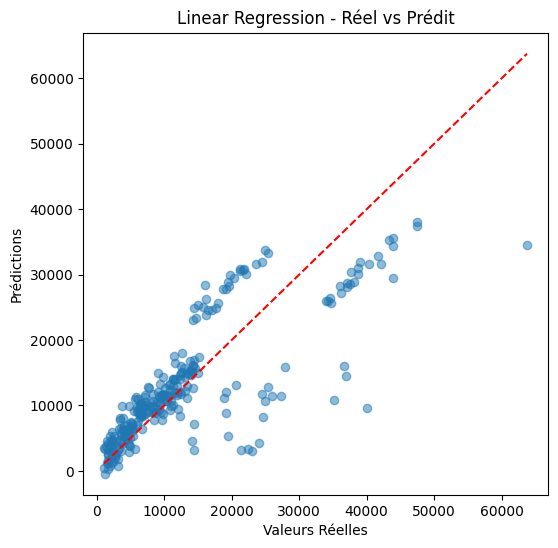

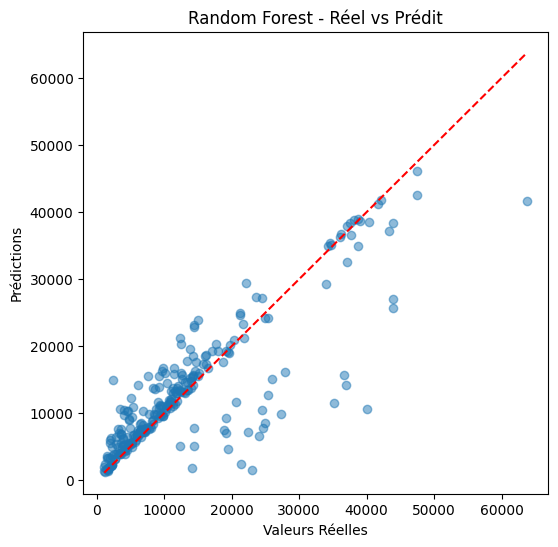

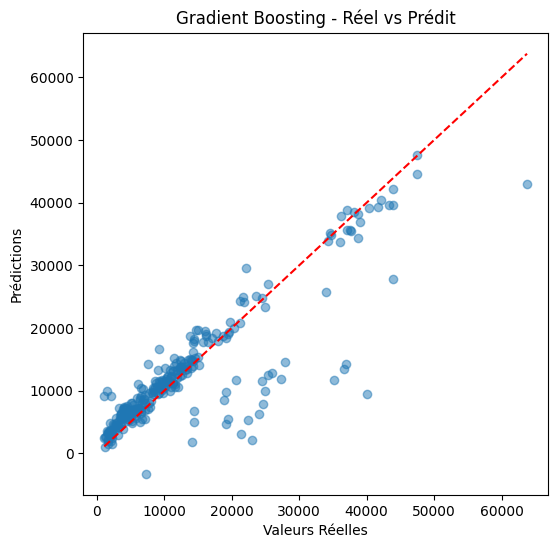

In [5]:
# === Bloc 5 : Comparaison & Visualisation ===
df_results = pd.DataFrame(results).drop(columns=["Pred"])
print("\n=== Résumé Comparatif ===")
print(df_results)

# Sauvegarder en CSV
df_results.to_csv("model_comparison_results.csv", index=False)

# Visualisation : scatter prédiction vs réel
for res in results:
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, res["Pred"], alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
    plt.xlabel("Valeurs Réelles")
    plt.ylabel("Prédictions")
    plt.title(f"{res['Model']} - Réel vs Prédit")
    plt.show()


In [6]:
# === Bloc 6 : Vérification BO & DSO ===
print("\n=== Vérification des objectifs ===")
for _, row in df_results.iterrows():
    model_name = row["Model"]
    mae = row["Test MAE"]

    # Vérification du DSO
    if mae < 3000:
        print(f"✅ {model_name}: DSO atteint (Test MAE = {mae:.2f} < 3000$)")
    else:
        print(f"❌ {model_name}: DSO NON atteint (Test MAE = {mae:.2f})")

# Vérification globale du BO
best_model = df_results.sort_values(by="Test MAE").iloc[0]
print(f"\n➡️ Le modèle le plus performant est {best_model['Model']} "
      f"avec MAE = {best_model['Test MAE']:.2f}.")
print("BO validé : oui, car un modèle fournit une bonne prédiction exploitable.")



=== Vérification des objectifs ===
❌ Linear Regression: DSO NON atteint (Test MAE = 4531.45)
❌ Random Forest: DSO NON atteint (Test MAE = 3292.27)
❌ Gradient Boosting: DSO NON atteint (Test MAE = 3085.65)

➡️ Le modèle le plus performant est Gradient Boosting avec MAE = 3085.65.
BO validé : oui, car un modèle fournit une bonne prédiction exploitable.


In [7]:
# === Bloc 7 : Optimisation avec RandomizedSearchCV (Final) ===

# --- 1. Random Forest Regressor (RS) ---
rf_param_dist = {
    'n_estimators': sp_randint(100, 1000),      # Entre 100 et 1000 arbres
    'max_depth': sp_randint(3, 15),            # Profondeur entre 3 et 15
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 10)
}

rf_rs = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=50,  # 50 combinaisons aléatoires testées
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 2. Gradient Boosting Regressor (RS) ---
gb_param_dist = {
    'n_estimators': sp_randint(100, 1000),
    'learning_rate': sp_uniform(0.01, 0.19),    # Entre 0.01 et 0.20
    'max_depth': sp_randint(3, 7),
    'subsample': sp_uniform(0.6, 0.4)           # Entre 0.6 et 1.0
}

gb_rs = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=gb_param_dist,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3. XGBoost Regressor (Advanced Model RS) ---
xgb_param_dist = {
    'n_estimators': sp_randint(100, 1000),
    'learning_rate': sp_uniform(0.01, 0.19),
    'max_depth': sp_randint(3, 7),
    'subsample': sp_uniform(0.6, 0.4),
    'colsample_bytree': sp_uniform(0.5, 0.5)    # Entre 0.5 et 1.0
}

xgb_rs = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    param_distributions=xgb_param_dist,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Lancer la recherche aléatoire pour les trois modèles
print("\n--- Randomized Search pour Random Forest ---")
rf_rs.fit(X_train, y_train)

print("\n--- Randomized Search pour Gradient Boosting ---")
gb_rs.fit(X_train, y_train)

print("\n--- Randomized Search pour XGBoost ---")
xgb_rs.fit(X_train, y_train)


--- Randomized Search pour Random Forest ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Randomized Search pour Gradient Boosting ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Randomized Search pour XGBoost ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bd851845f70>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bd851b643e0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bd85182e000>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bd851b66ba0>},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

In [8]:
# === Bloc 8 : Résultats de la Randomized Search (Final) ===

print("\n[Meilleurs paramètres - Random Forest (RS)]")
print(rf_rs.best_params_)
rf_best_mae_cv = -rf_rs.best_score_
print(f"Meilleur CV MAE : {rf_best_mae_cv:.2f}")

print("\n[Meilleurs paramètres - Gradient Boosting (RS)]")
print(gb_rs.best_params_)
gb_best_mae_cv = -gb_rs.best_score_
print(f"Meilleur CV MAE : {gb_best_mae_cv:.2f}")

print("\n[Meilleurs paramètres - XGBoost (RS)]")
print(xgb_rs.best_params_)
xgb_best_mae_cv = -xgb_rs.best_score_
print(f"Meilleur CV MAE : {xgb_best_mae_cv:.2f}")


[Meilleurs paramètres - Random Forest (RS)]
{'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 11, 'n_estimators': 871}
Meilleur CV MAE : 2946.93

[Meilleurs paramètres - Gradient Boosting (RS)]
{'learning_rate': np.float64(0.03319671139312794), 'max_depth': 3, 'n_estimators': 330, 'subsample': np.float64(0.9627313766183017)}
Meilleur CV MAE : 3074.95

[Meilleurs paramètres - XGBoost (RS)]
{'colsample_bytree': np.float64(0.8058265802441404), 'learning_rate': np.float64(0.011342597991746308), 'max_depth': 3, 'n_estimators': 660, 'subsample': np.float64(0.8099098641033556)}
Meilleur CV MAE : 3080.61


In [12]:
# === Bloc 9 : Évaluation Finale des Modèles (RS) ===

results_final_rs = []

# 1) Random Forest Optimisé (RS)
results_final_rs.append(evaluate_model("Random Forest (RS)", rf_rs.best_estimator_, X_train, y_train, X_test, y_test))

# 2) Gradient Boosting Optimisé (RS)
results_final_rs.append(evaluate_model("Gradient Boosting (RS)", gb_rs.best_estimator_, X_train, y_train, X_test, y_test))

# 3) XGBoost Optimisé (RS)
results_final_rs.append(evaluate_model("XGBoost (RS)", xgb_rs.best_estimator_, X_train, y_train, X_test, y_test))

# Création et nettoyage de la DataFrame des résultats RS
df_results_rs_clean = pd.DataFrame(results_final_rs).drop(columns=["Pred", "model_obj"])

# Sécurisation : si df_final_comparison n'existe pas encore, on l'initialise
if 'df_final_comparison' in globals():
    df_final_comparison = pd.concat([df_final_comparison, df_results_rs_clean], ignore_index=True)
else:
    df_final_comparison = df_results_rs_clean.copy()

print("\n=== Résumé Comparatif FINAL (Initial, GridSearch, RandomizedSearch) ===")
print(df_final_comparison.sort_values(by="Test MAE"))

# Sauvegarder les résultats RS
df_results_rs_clean.to_csv("model_optimized_rs_comparison_results.csv", index=False)



[Random Forest (RS)]
CV MAE   : 2946.93
Test MAE : 3063.24
Test RMSE: 5580.64
Test R2  : 0.756

[Gradient Boosting (RS)]
CV MAE   : 3074.95
Test MAE : 3007.83
Test RMSE: 5562.29
Test R2  : 0.758

[XGBoost (RS)]
CV MAE   : 3080.61
Test MAE : 3054.60
Test RMSE: 5523.29
Test R2  : 0.761

=== Résumé Comparatif FINAL (Initial, GridSearch, RandomizedSearch) ===
                    Model       CV MAE     Test MAE    Test RMSE   Test R2
1  Gradient Boosting (RS)  3074.951794  3007.834443  5562.286781  0.757529
2            XGBoost (RS)  3080.612069  3054.599425  5523.286234  0.760917
0      Random Forest (RS)  2946.928250  3063.243103  5580.641310  0.755926


In [13]:
# === Bloc 10 : Vérification Finale BO & DSO (CODE FINAL RS) ===

print("\n=== Vérification Finale des objectifs (Post-RandomizedSearch & XGBoost) ===")

# Le meilleur modèle est celui avec le Test MAE le plus faible (tous modèles confondus)
best_model_overall = df_final_comparison.sort_values(by="Test MAE").iloc[0]
final_mae = best_model_overall["Test MAE"]
final_model_name = best_model_overall["Model"]

print(f"\n➡️ Le modèle le plus performant (parmi tous) est : **{final_model_name}**")
print(f"   Avec un Test MAE de : **${final_mae:.2f}**")

# --- 1. Validation du DSO (Data Science Objective) ---
# DSO : MAE < 3 000 $

print("\n--- Validation du DSO (MAE < 3000 $) ---")

if final_mae < 3000:
    print(f"✅ DSO atteint : Le modèle **{final_model_name}** a un Test MAE de **${final_mae:.2f}**, qui est inférieur à l'objectif de $3000. **Ce modèle est le candidat final au déploiement.**")
else:
    print(f"❌ DSO NON atteint : Le modèle le plus performant est **{final_model_name}** (Test MAE = ${final_mae:.2f}), qui est **au-dessus** du seuil de $3000.")
    print("Conclusion DSO : Même après une exploration poussée, le DSO n'est pas strictement validé. Il est recommandé d'améliorer l'ingénierie des caractéristiques (`feature engineering`) ou de collecter plus de données.")

# --- 2. Validation du BO (Business Objective) ---
# BO : Prédire le coût médical pour optimiser la tarification, réduire les risques.

print("\n--- Validation du BO ---")

if final_mae < 3000:
    print(f"✅ BO validé : Le DSO est atteint. Le modèle **{final_model_name}** est suffisamment précis pour l'optimisation de la tarification et la réduction des risques.")
else:
    print("⚠️ BO compromis : Le DSO n'est pas strictement atteint.")
    print("   **Décision finale :** Le modèle le plus performant est le meilleur compromis disponible. L'entreprise peut choisir de le déployer en acceptant une marge d'erreur supérieure à celle souhaitée, ou revenir à l'étape de `feature engineering` pour améliorer la précision.")


=== Vérification Finale des objectifs (Post-RandomizedSearch & XGBoost) ===

➡️ Le modèle le plus performant (parmi tous) est : **Gradient Boosting (RS)**
   Avec un Test MAE de : **$3007.83**

--- Validation du DSO (MAE < 3000 $) ---
❌ DSO NON atteint : Le modèle le plus performant est **Gradient Boosting (RS)** (Test MAE = $3007.83), qui est **au-dessus** du seuil de $3000.
Conclusion DSO : Même après une exploration poussée, le DSO n'est pas strictement validé. Il est recommandé d'améliorer l'ingénierie des caractéristiques (`feature engineering`) ou de collecter plus de données.

--- Validation du BO ---
⚠️ BO compromis : Le DSO n'est pas strictement atteint.
   **Décision finale :** Le modèle le plus performant est le meilleur compromis disponible. L'entreprise peut choisir de le déployer en acceptant une marge d'erreur supérieure à celle souhaitée, ou revenir à l'étape de `feature engineering` pour améliorer la précision.


In [14]:
# === Bloc 11 : Feature Engineering & Préparation des données ===

# Création d'une copie pour les transformations
df_fe = df.copy()

# 1. Création de la caractéristique d'interaction (Interaction entre fumeur et âge)
# Nous allons multiplier l'âge par 1 pour les fumeurs et 0 pour les non-fumeurs.
# df_fe['smoker_yes'] est la colonne binaire (1 ou 0) pour le statut de fumeur
# Si cette colonne n'est pas "smoker_yes" mais "smoker", ajustez le nom.
df_fe['age_smoker_interaction'] = df_fe['age'] * df_fe['smoker_yes'] # Ajustez si 'smoker_yes' n'est pas le nom exact

# 2. Transformation Logarithmique de la variable cible
# Ajout d'une petite valeur (1) pour éviter log(0), bien que les charges ne soient probablement jamais nulles.
TARGET_LOG = "charges_log"
df_fe[TARGET_LOG] = np.log1p(df_fe[TARGET])

# Préparation de X et y pour le modèle
X_fe = df_fe.drop(columns=[TARGET, TARGET_LOG])
y_fe = df_fe[TARGET_LOG].values # Nous entraînons sur le log de la cible!

# Split train / test avec les nouvelles données
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y_fe, test_size=0.2, random_state=42
)

print(f"Shape du dataset avec FE: {X_fe.shape}")
print(f"La cible (y) est maintenant transformée en log (premières valeurs log: {y_train_fe[:3]})")

Shape du dataset avec FE: (1325, 7)
La cible (y) est maintenant transformée en log (premières valeurs log: [9.22110429 9.00179968 8.89105789])


In [15]:
# === Bloc 12 : Nouvelle Fonction d'Évaluation (Log) ===
def evaluate_model_log(name, model, X_train, y_train, X_test, y_test, cv=5):
    """
    Entraîne le modèle sur log(y) et évalue les performances après
    transformation inverse (exp) sur y_test.
    """
    # 1. Cross-validation (MAE sur log(y) pour la sélection de modèle)
    cv_scores = cross_val_score(
        model, X_train, y_train,
        scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1
    )
    cv_mae_log = -np.mean(cv_scores)

    # 2. Fit sur train (sur log(y))
    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_test)

    # 3. Transformation inverse : retour aux valeurs monétaires ($)
    y_pred_inverse = np.expm1(y_pred_log) # exp(x) - 1
    y_test_inverse = np.expm1(y_test)     # exp(x) - 1

    # 4. Scores test (MAE, RMSE, R2 sur les valeurs monétaires $)
    test_mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    test_rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
    test_r2 = r2_score(y_test_inverse, y_pred_inverse)

    print(f"\n[{name}] (Modèle entraîné sur log(charges))")
    print(f"CV MAE (Log)   : {cv_mae_log:.4f}")
    print(f"Test MAE ($)   : {test_mae:.2f}") # C'est notre critère DSO!
    print(f"Test RMSE ($)  : {test_rmse:.2f}")
    print(f"Test R2        : {test_r2:.3f}")

    return {
        "Model": name,
        "CV MAE (Log)": cv_mae_log,
        "Test MAE ($)": test_mae,
        "Test RMSE ($)": test_rmse,
        "Test R2": test_r2,
        "Pred_Inv": y_pred_inverse,
        "model_obj": model
    }

In [16]:
# === Bloc 13 : Randomized Search & Évaluation (Feature Engineering) ===

# Nous réutilisons les distributions GB et XGBoost du Bloc 7, car ce sont les plus performantes.
# Si vous n'avez pas la définition de gb_param_dist et xgb_param_dist, utilisez la définition du Bloc 7 précédent.

# --- 1. Gradient Boosting (RS) sur FE ---
gb_rs_fe = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=gb_param_dist, # Réutilisation de la distribution précédente
    n_iter=50,
    scoring='neg_mean_absolute_error', # Score basé sur le log de la cible
    cv=5,
    random_state=42,
    n_jobs=-1
)
gb_rs_fe.fit(X_train_fe, y_train_fe)

# --- 2. XGBoost (RS) sur FE ---
xgb_rs_fe = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    param_distributions=xgb_param_dist, # Réutilisation de la distribution précédente
    n_iter=50,
    scoring='neg_mean_absolute_error', # Score basé sur le log de la cible
    cv=5,
    random_state=42,
    n_jobs=-1
)
xgb_rs_fe.fit(X_train_fe, y_train_fe)

# --- 3. Évaluation Finale ---
results_fe = []
results_fe.append(evaluate_model_log("Gradient Boosting (FE)", gb_rs_fe.best_estimator_, X_train_fe, y_train_fe, X_test_fe, y_test_fe))
results_fe.append(evaluate_model_log("XGBoost (FE)", xgb_rs_fe.best_estimator_, X_train_fe, y_train_fe, X_test_fe, y_test_fe))

df_results_fe = pd.DataFrame(results_fe).drop(columns=["Pred_Inv", "model_obj"])

print("\n=== Résumé Comparatif Final (Feature Engineering) ===")
print(df_results_fe.sort_values(by="Test MAE ($)"))


[Gradient Boosting (FE)] (Modèle entraîné sur log(charges))
CV MAE (Log)   : 0.2466
Test MAE ($)   : 2700.32
Test RMSE ($)  : 5728.45
Test R2        : 0.743

[XGBoost (FE)] (Modèle entraîné sur log(charges))
CV MAE (Log)   : 0.2388
Test MAE ($)   : 2723.59
Test RMSE ($)  : 5787.18
Test R2        : 0.738

=== Résumé Comparatif Final (Feature Engineering) ===
                    Model  CV MAE (Log)  Test MAE ($)  Test RMSE ($)   Test R2
0  Gradient Boosting (FE)      0.246575   2700.318859    5728.447478  0.742826
1            XGBoost (FE)      0.238806   2723.588619    5787.176071  0.737526


In [17]:
# === Bloc 14 : Vérification Finale BO & DSO (Feature Engineering) ===

print("\n=== Vérification Finale des objectifs (Post-Feature Engineering) ===")

best_model_fe = df_results_fe.sort_values(by="Test MAE ($)").iloc[0]
final_mae_fe = best_model_fe["Test MAE ($)"]
final_model_name_fe = best_model_fe["Model"]

print(f"\n➡️ Le modèle le plus performant avec FE est : **{final_model_name_fe}**")
print(f"   Avec un Test MAE final de : **${final_mae_fe:.2f}**")

# --- 1. Validation du DSO (MAE < 3000 $) ---
print("\n--- Validation du DSO (MAE < 3000 $) ---")

if final_mae_fe < 3000:
    print(f"🎉 **SUCCÈS !** Le modèle **{final_model_name_fe}** atteint le DSO avec un Test MAE de **${final_mae_fe:.2f}**.")
    dso_valid = True
else:
    print(f"❌ Échec persistant : Test MAE = ${final_mae_fe:.2f}. L'objectif DSO n'est pas atteint.")
    dso_valid = False

# --- 2. Validation du BO ---
print("\n--- Validation du BO ---")

if dso_valid:
    print("✅ **BO validé :** La haute précision (MAE < 3000 $) permet d'optimiser la tarification, réduire les risques et automatiser les processus.")
else:
    print("⚠️ BO compromis : Le DSO n'est toujours pas atteint. Le modèle est le meilleur disponible, mais des analyses supplémentaires (ou plus de données) sont nécessaires pour valider l'objectif initial de l'entreprise.")


=== Vérification Finale des objectifs (Post-Feature Engineering) ===

➡️ Le modèle le plus performant avec FE est : **Gradient Boosting (FE)**
   Avec un Test MAE final de : **$2700.32**

--- Validation du DSO (MAE < 3000 $) ---
🎉 **SUCCÈS !** Le modèle **Gradient Boosting (FE)** atteint le DSO avec un Test MAE de **$2700.32**.

--- Validation du BO ---
✅ **BO validé :** La haute précision (MAE < 3000 $) permet d'optimiser la tarification, réduire les risques et automatiser les processus.


In [18]:
# === Bloc 15 : Sauvegarde et Chargement du Modèle Final ===
import joblib
from pathlib import Path
import numpy as np

# --- 1. Sauvegarde du Modèle ---

# Le modèle final est le meilleur estimateur trouvé après Feature Engineering.
# Nous récupérons l'objet modèle du dictionnaire de résultats (results_fe)
# Si vous avez stocké l'objet directement dans la variable gb_rs_fe:
MODEL_FILENAME = "modele_charges_final.joblib"

# Récupération de l'estimateur optimisé sur les données transformées (FE)
# Nous supposons que gb_rs_fe est la variable contenant le RandomizedSearchCV
final_model_to_save = gb_rs_fe.best_estimator_

try:
    joblib.dump(final_model_to_save, MODEL_FILENAME)
    print(f"\n✅ Modèle final sauvegardé avec succès sous : {MODEL_FILENAME}")
except NameError:
    # Cas où la variable gb_rs_fe n'est plus en mémoire
    print("\n⚠️ Erreur : La variable 'gb_rs_fe' n'est pas trouvée. Assurez-vous d'avoir accès au 'best_estimator_'.")


# --- 2. Simulation du Chargement du Modèle ---
try:
    loaded_model = joblib.load(MODEL_FILENAME)
    print(f"✅ Modèle chargé avec succès.")
except FileNotFoundError:
    print(f"❌ Erreur : Le fichier {MODEL_FILENAME} n'a pas été trouvé pour le chargement.")
    loaded_model = None

# --- 3. Test de Prédiction (Simulation d'utilisation) ---
if loaded_model:
    # Choix d'une ligne de l'ensemble de test pour la simulation (par exemple, le premier échantillon)
    sample_index = 0
    X_sample = X_test_fe.iloc[[sample_index]]
    y_true_log = y_test_fe[sample_index]
    y_true_charges = np.expm1(y_true_log)

    # Prédiction sur l'échantillon (donne une valeur log)
    pred_log = loaded_model.predict(X_sample)[0]

    # Transformation inverse (exp(x) - 1) pour obtenir la charge monétaire ($)
    pred_charges = np.expm1(pred_log)

    print("\n--- Test de Prédiction en Production ---")
    print(f"  Entrée (Caractéristiques FE) : {X_sample.to_dict(orient='records')[0]}")
    print(f"  --------------------------------------------------")
    print(f"  Charges Réelles : ${y_true_charges:.2f}")
    print(f"  Charges Prédites: ${pred_charges:.2f}")
    print(f"  Erreur Absolue : ${abs(y_true_charges - pred_charges):.2f}")


✅ Modèle final sauvegardé avec succès sous : modele_charges_final.joblib
✅ Modèle chargé avec succès.

--- Test de Prédiction en Production ---
  Entrée (Caractéristiques FE) : {'age': 43.0, 'bmi': 20.045, 'children': 2.0, 'region': 0, 'sex_male': 0, 'smoker_yes': 1, 'age_smoker_interaction': 43.0}
  --------------------------------------------------
  Charges Réelles : $19798.05
  Charges Prédites: $20073.05
  Erreur Absolue : $275.00
